In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.nn import GATv2Conv
from torch_geometric.nn import GINConv
from torch_geometric.nn import global_mean_pool, global_add_pool
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import MessagePassing
import torch.optim as optim

In [2]:
import scipy.sparse as sp
import numpy as np
import json
from torch_geometric.utils import from_scipy_sparse_matrix
import torch
from torch import nn
adj = sp.load_npz('/Users/michaelguel/Desktop/ProjectData/data_2024/adj.npz')
feat  = np.load('/Users/michaelguel/Desktop/ProjectData/data_2024/features.npy')
labels = np.load('/Users/michaelguel/Desktop/ProjectData/data_2024/labels.npy')
splits = json.load(open('/Users/michaelguel/Desktop/ProjectData/data_2024/splits.json'))
idx_train, idx_test = splits['idx_train'], splits['idx_test']

In [3]:
labelss = torch.LongTensor(labels)
feats = torch.FloatTensor(feat)


In [4]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight = 'balanced',classes = np.unique(labels),y=labels)

weightsentropy = torch.tensor(class_weights,dtype=torch.float)

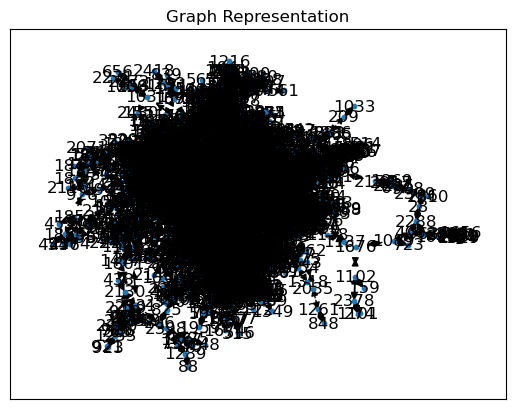

In [504]:
import networkx as nx
import scipy.sparse as sp
import matplotlib.pyplot as plt
#figsize = (100,100)

# Assuming csr_matrix is your adjacency matrix
G = nx.from_scipy_sparse_array(adj, create_using=nx.DiGraph())
pos = nx.spring_layout(G)  # positions for all nodes

nx.draw_networkx_nodes(G, pos, node_size=10)
nx.draw_networkx_edges(G, pos, edgelist=[(u, v) for u, v in G.edges()], width=1)
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

plt.title('Graph Representation')
plt.show()

In [5]:
import scipy.sparse as sp
import numpy as np

def compute_jaccard_coefficient(adjacency_matrix):
    adjacency_coo = adj.tocoo()
    edge_features = []
    
    for i,j in zip(adjacency_coo.row, adjacency_coo.col):
        neighbors_i = set(adjacency_matrix[i].indices)
        neighbors_j = set(adjacency_matrix[j].indices)
        
        intersection = len(neighbors_i.intersection(neighbors_j))
        union = len(neighbors_i.union(neighbors_j))
        
        jaccard = intersection / union if union != 0 else 0
        edge_features.append((i,j, jaccard))
    return edge_features



In [6]:
edge_features = compute_jaccard_coefficient(adj)
edge_index = torch.tensor([[src,tgt]for src,tgt, _ in edge_features],dtype=torch.long).t()
edge_attr = torch.tensor([coef for _, _, coef in edge_features],dtype=torch.float)

In [7]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels,out_channels,heads=8,dim_h=16):
        super(GAT,self).__init__()
        self.gat1 = GATv2Conv(in_channels,dim_h,heads=heads,concat=True,edge_dim=1)
        self.gat2 = GATv2Conv(dim_h*heads,dim_h,heads=heads,concat=True,edge_dim=1)
        self.gat3 = GATv2Conv(dim_h*heads,out_channels,heads=heads,concat=False,edge_dim=1)
        
    def forward(self, data):
        x = data.x
        edge_attr = data.edge_attr
        edge_index = data.edge_index
            
        #x = F.dropout(x,p=0.5,training=self.training)
        x = F.elu(self.gat1(x,edge_index,edge_attr))
        x = F.dropout(x,p=0.5,training=self.training)
        x = F.elu(self.gat2(x,edge_index,edge_attr))
        x = F.dropout(x,p=0.5,training=self.training)
        x = self.gat3(x,edge_index,edge_attr)
        #x = global_mean_pool(x,torch.zeros(x.size(0),dtype=torch.long))
        
        
        return F.log_softmax(x,dim=1)
    
def accuracy(pred_y,y):
    
    return ((pred_y == y).sum()/len(y)).item()
    

In [8]:
num_nodes = feats.shape[0]
num_features = feats.shape[1]
x = feats

num_edges = edge_index.size(1)

edge_index = edge_index

num_edge_features = 1

edge_attr = edge_attr

y = labelss

dset = Data(x=x, edge_index=edge_index, edge_attr=edge_attr ,y=y, no_mask = idx_train, train_mask = idx_train[:398], val_mask = idx_train[398:], test_mask = idx_test)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = dset.to(device)

model2 = GAT(in_channels = data.num_features, 
             out_channels = (data.y.max()+1).item(),
             heads = 16,
            dim_h=16)


optimizer = torch.optim.Adam(model2.parameters(), lr=0.0007, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.02,patience=2,threshold=0.01)
#optimizer = torch.optim.Adam(model2.parameters(), lr=0.0005, weight_decay=5e-4)
criterion = torch.nn.NLLLoss(weight = weightsentropy)
#criterion2 = torch.nn.NLLLoss(weight = weightsentropy2)
#criterion = torch.nn.CrossEntropyLoss(weight = weightsentropy)
    
#model2.train()
for epoch in range(200):
    model2.train()
    optimizer.zero_grad()
    out = model2(data)
    loss = criterion(out[data.train_mask], data.y[:398])
    loss.backward()
    optimizer.step()
    trainaccuracy = accuracy(out[data.train_mask].argmax(dim=1),data.y[:398])
    model2.eval()
    with torch.no_grad():
        valaccuracy = accuracy(out[data.val_mask].argmax(dim=1),data.y[398:])
        valloss = criterion(out[data.val_mask], data.y[398:])
    scheduler.step(valloss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train Loss: {loss.item()}, Val Loss: {valloss.item()},Val Accuracy: {valaccuracy}")
    #model2.train()
    #print(f"Epoch {epoch}: Train Loss: {loss.item()}, Train Accuracy: {trainaccuracy}: Val Loss: {valloss}: Val Accuracy: {valaccuracy}")
    #model2.train()



Epoch 0: Train Loss: 1.946614384651184, Val Loss: 1.9519550800323486,Val Accuracy: 0.08163265138864517
Epoch 10: Train Loss: 1.724399447441101, Val Loss: 1.7623281478881836,Val Accuracy: 0.7755101919174194
Epoch 20: Train Loss: 1.2816592454910278, Val Loss: 1.3590556383132935,Val Accuracy: 0.7857142686843872
Epoch 30: Train Loss: 0.6808498501777649, Val Loss: 0.8322024941444397,Val Accuracy: 0.8163265585899353
Epoch 40: Train Loss: 0.35137784481048584, Val Loss: 0.5947261452674866,Val Accuracy: 0.8367347121238708
Epoch 50: Train Loss: 0.2718558609485626, Val Loss: 0.5767698287963867,Val Accuracy: 0.8367347121238708
Epoch 60: Train Loss: 0.26694121956825256, Val Loss: 0.607174813747406,Val Accuracy: 0.8469387888908386
Epoch 70: Train Loss: 0.27206695079803467, Val Loss: 0.6014648079872131,Val Accuracy: 0.8571428656578064
Epoch 80: Train Loss: 0.2635805010795593, Val Loss: 0.5733512043952942,Val Accuracy: 0.8367347121238708
Epoch 90: Train Loss: 0.2650972604751587, Val Loss: 0.5809773206

In [ ]:
# import pandas as pd

# traindf = pd.DataFrame(epochtrainloss, columns = ['Train Loss']) 
# valdf = pd.DataFrame(epochvalloss, columns=['Validation Loss'])

# traindf.to_csv('trainloss.csv',index=False)
# valdf.to_csv('validationloss.csv',index=False)

In [ ]:
# best_model_cp = torch.load('outputs_best_model.pth')

# best_model_epoch = best_model_cp['epoch']

# print(best_model_epoch)

# model2.load_state_dict(best_model_cp['model_state_dict'])

# print(model2)

In [10]:
torch.save({
    'model_state_dict': model2.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, 'model_checkpoint.pth')

In [49]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import StepLR
model = model2(data)
optimizer = optim.Adam(model2.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=5,gamma=.5)

checkpoint = torch.load('model_checkpoint.pth')
model2.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
criterion = torch.nn.NLLLoss()

In [50]:
model2.train()

for epoch in range(100):
    optimizer.zero_grad()
    out = model2(data)
    loss = criterion(out[data.no_mask], data.y)
    loss.backward()
    optimizer.step()
    trainaccuracy = accuracy(out[data.no_mask].argmax(dim=1),data.y)
    scheduler.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train Loss: {loss.item()}")

Epoch 0: Train Loss: 0.3542935252189636
Epoch 10: Train Loss: 0.23326410353183746
Epoch 20: Train Loss: 0.21843484044075012
Epoch 30: Train Loss: 0.20663383603096008
Epoch 40: Train Loss: 0.21240533888339996
Epoch 50: Train Loss: 0.207749143242836
Epoch 60: Train Loss: 0.2083347588777542
Epoch 70: Train Loss: 0.20838101208209991
Epoch 80: Train Loss: 0.20689740777015686
Epoch 90: Train Loss: 0.20614856481552124


In [25]:
model2(data)
model2.eval()
pred = model2(data).argmax(dim=1)
correct = (pred[data.no_mask] == data.y).sum()
acc = int(correct) / len(data.y)
print(f'Accuracy: {acc:.4f}')
print(pred.shape)

Accuracy: 0.8972
torch.Size([2480])


In [499]:
from torchviz import make_dot

outputs = model2(data)

make_dot(outputs, params = dict(list(model2.named_parameters()))).render("Network Architecture", format='png')

'Network Architecture.png'

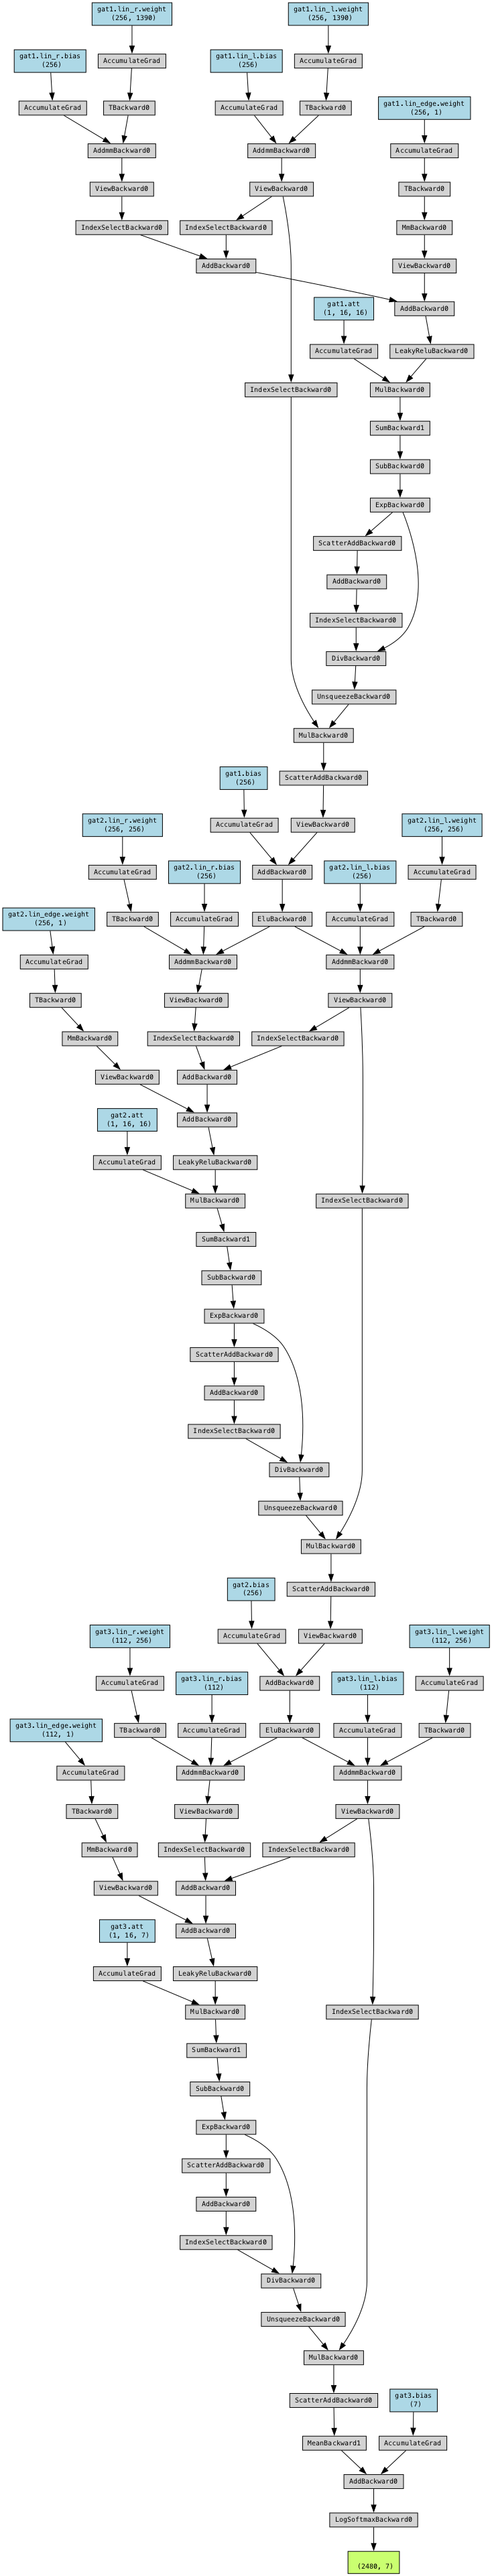

In [500]:
from IPython.display import Image
Image('Network Architecture.png')

In [16]:
predss = model2(data).argmax(dim=1)

preds = predss[data.test_mask]

np.savetxt('submissionfinalupload.txt',preds,fmt='%d')